In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test_vc2kHdQ.csv
/kaggle/input/sample_submission_yxjOnvz.csv
/kaggle/input/train.csv
/kaggle/input/images/2345.jpg
/kaggle/input/images/170.jpg
/kaggle/input/images/1879.jpg
/kaggle/input/images/438.jpg
/kaggle/input/images/2257.jpg
/kaggle/input/images/1886.jpg
/kaggle/input/images/1183.jpg
/kaggle/input/images/968.jpg
/kaggle/input/images/1024.jpg
/kaggle/input/images/234.jpg
/kaggle/input/images/2045.jpg
/kaggle/input/images/1299.jpg
/kaggle/input/images/458.jpg
/kaggle/input/images/1556.jpg
/kaggle/input/images/2210.jpg
/kaggle/input/images/1885.jpg
/kaggle/input/images/580.jpg
/kaggle/input/images/2327.jpg
/kaggle/input/images/510.jpg
/kaggle/input/images/930.jpg
/kaggle/input/images/2351.jpg
/kaggle/input/images/1514.jpg
/kaggle/input/images/1701.jpg
/kaggle/input/images/287.jpg
/kaggle/input/images/87.jpg
/kaggle/input/images/1999.jpg
/kaggle/input/images/1460.jpg
/kaggle/input/images/1200.jpg
/kaggle/input/images/1921.jpg
/kaggle/input/images/404.jpg
/kaggle/input

/kaggle/input/images/214.jpg
/kaggle/input/images/1869.jpg
/kaggle/input/images/2290.jpg
/kaggle/input/images/1799.jpg
/kaggle/input/images/2299.jpg
/kaggle/input/images/2193.jpg
/kaggle/input/images/1172.jpg
/kaggle/input/images/795.jpg
/kaggle/input/images/1224.jpg
/kaggle/input/images/187.jpg
/kaggle/input/images/1837.jpg
/kaggle/input/images/423.jpg
/kaggle/input/images/1923.jpg
/kaggle/input/images/1348.jpg
/kaggle/input/images/1626.jpg
/kaggle/input/images/145.jpg
/kaggle/input/images/1599.jpg
/kaggle/input/images/2150.jpg
/kaggle/input/images/916.jpg
/kaggle/input/images/2179.jpg
/kaggle/input/images/2143.jpg
/kaggle/input/images/1991.jpg
/kaggle/input/images/1330.jpg
/kaggle/input/images/1395.jpg
/kaggle/input/images/1480.jpg
/kaggle/input/images/872.jpg
/kaggle/input/images/2247.jpg
/kaggle/input/images/60.jpg
/kaggle/input/images/680.jpg
/kaggle/input/images/385.jpg
/kaggle/input/images/2280.jpg
/kaggle/input/images/1803.jpg
/kaggle/input/images/2220.jpg
/kaggle/input/images/

In [2]:
path= '/kaggle/input/'
k= '/kaggle/input/train.csv'
p ='/kaggle/input/test_vc2kHdQ.csv'

In [3]:
train=pd.read_csv(k)
test=pd.read_csv(p)

In [4]:

train.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [5]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob

In [6]:
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch
from fastai.callbacks.hooks import *

In [7]:

path ='/kaggle/input/images/'
tfms = get_transforms(flip_vert=False,max_zoom=1.0,max_warp=0,do_flip=False,xtra_tfms=[cutout()])
data = (ImageList.from_csv(path, csv_name = '../train.csv')
        .split_by_rand_pct()              
        .label_from_df()            
        .add_test_folder(test_folder = '../images')              
        .transform(tfms, size=400)
        .databunch(num_workers=0,bs=8))

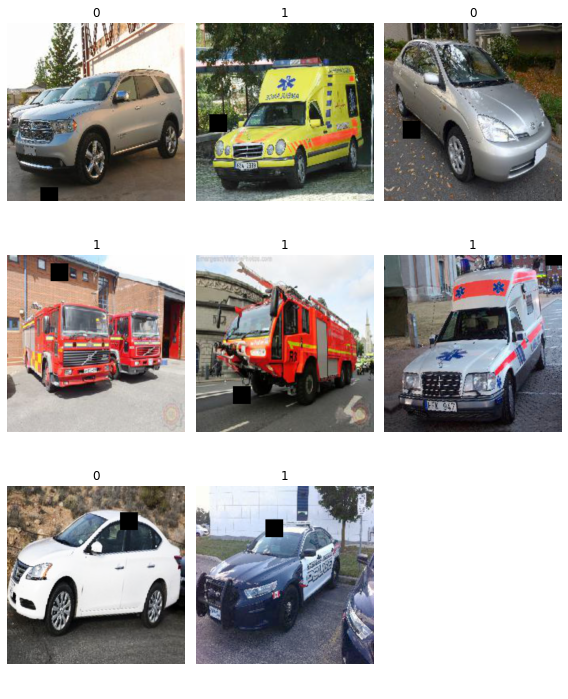

In [8]:
data.show_batch(rows=3, figsize=(8,10))

In [9]:
print(data.classes)

[0, 1]


In [10]:
learn = cnn_learner(data, models.densenet169, metrics=[error_rate, accuracy], model_dir="/tmp/model/")

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/checkpoints/densenet201-c1103571.pth


In [15]:

from fastai import *
from fastai.vision import *
from sklearn.model_selection import StratifiedKFold
from pathlib import Path
import shutil
from sklearn.metrics import f1_score, confusion_matrix

np.random.seed(1786)
ROOT = "/tmp/data0"

In [16]:
def read_data(root):
    train_df = pd.read_csv(k)
    test_df = pd.read_csv(p)
    return train_df, test_df

In [17]:
class SaveBestModel(Recorder):
    def __init__(self, learn,name='best_model'):
        super().__init__(learn)
        self.name = name
        self.best_loss = None
        self.best_acc = None
        self.save_method = self.save_when_acc
        
    def save_when_acc(self, metrics):        
        loss, acc = metrics[0], metrics[1]
        if (self.best_acc is None) or (acc > self.best_acc) or (loss < self.best_loss):
            self.best_acc = acc
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Save the best acc {:.5f}".format(self.best_acc))
        elif acc == self.best_acc and  loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Acc is eq,Save the lower loss {:.5f}".format(self.best_loss))
            
    def on_epoch_end(self,last_metrics=MetricsList,**kwargs:Any):
        self.save_method(last_metrics)

In [18]:
#Path(ROOT).mkdir(exist_ok=True, parents=True)
src1 = "/kaggle/input/"
shutil.copytree(src1, ROOT)


if __name__=="__main__":
    train_df, test_df = read_data(ROOT)
    print(train_df.shape, test_df.shape)
    
    cvlist = list(StratifiedKFold(8, random_state=2**15).split(train_df, train_df.emergency_or_not))
    
    tfms1 = get_transforms(max_zoom=1.5)
    test_preds_all = []
    val_preds_all = []
    for i in range(1):
        print("Starting fold {}".format(i))
        tr_idx, val_idx = cvlist[i]
        print(tr_idx.shape, val_idx.shape)
        src = (ImageList.from_df(train_df, path=ROOT, folder="images").split_by_idxs(tr_idx, val_idx)
                                                            .label_from_df())
        data = ImageDataBunch.create_from_ll(src, ds_tfms=tfms1, size=400, bs=8, resize_method=3).normalize(imagenet_stats)
        data.add_test(ImageList.from_df(test_df, path=ROOT, folder="images"))
        learn = cnn_learner(data, models.densenet169, metrics=accuracy, ps=0.5)
        # learn.model[0].load_state_dict(torch.load("../input/save-body-weights-marvel/bestmodel_body.path"))
        cb = SaveBestModel(learn, name="bestmodel_{}".format(i))
        #learn.fit(1, callbacks=cb)
        learn.fit_one_cycle(8)
        learn.unfreeze()
        learn.fit_one_cycle(10, max_lr=1e-4, callbacks=[cb])
        #learn.fit_one_cycle(10, max_lr=5e-5, callbacks=[cb])
        #learn.fit_one_cycle(10, max_lr=1e-5, callbacks=[cb])
        #learn.fit_one_cycle(10, max_lr=5e-6, callbacks=[cb])
        learn.fit_one_cycle(2, max_lr=1e-6, callbacks=[cb])
        learn.load("bestmodel_{}".format(i))
        val_preds, y = learn.TTA(ds_type=DatasetType.Valid)
        val_preds = np.exp(val_preds.numpy())
        print("F1 score for this fold ",f1_score(y.numpy(), np.argmax(val_preds,axis=1), average='weighted'))
        test_preds = np.exp(learn.TTA(ds_type=DatasetType.Test)[0].numpy())
        test_preds_all.append(test_preds)
        val_preds_all.append(val_preds)
        fname = "bestmodel_{}.pth".format(i)
        src = str(Path(ROOT) / "models" / fname)
        shutil.copy(src, fname)
    test_preds_all = np.mean(test_preds_all, axis=0)
    val_preds_all = np.concatenate(val_preds_all, axis=0)

    np.save("test_preds.npy", test_preds_all)
    np.save("val_preds.npy", val_preds_all)
    sub = test_df[["image_names"]]
    sub["emergency_or_not"] = np.argmax(test_preds_all, axis=1)
    sub.to_csv("zyk.csv", index=False)

(1646, 2) (706, 1)
Starting fold 0
(1440,) (206,)


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


epoch,train_loss,valid_loss,accuracy,time
0,0.604702,0.239449,0.927184,00:59
1,0.440476,0.241681,0.927184,00:54
2,0.353762,0.186484,0.936893,00:54
3,0.294873,0.157143,0.956311,00:53
4,0.287162,0.155970,0.936893,00:53
5,0.269311,0.132330,0.970874,00:54
6,0.196378,0.103019,0.975728,00:53
7,0.189438,0.104575,0.975728,00:52


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.192395,0.103799,0.980583,01:06
1,0.235350,0.123797,0.975728,01:04
2,0.213222,0.141071,0.956311,01:03
3,0.243583,0.157293,0.951456,01:03
4,0.191573,0.117125,0.956311,01:03
5,0.211916,0.219728,0.927184,01:03
6,0.142586,0.119949,0.961165,01:03
7,0.129749,0.121355,0.961165,01:03
8,0.096751,0.097858,0.966019,01:03


Save the best acc 0.98058
Save the best acc 0.96602
Save the best acc 0.96602


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.124974,0.100603,0.961165,01:03
1,0.109771,0.101602,0.961165,01:02


F1 score for this fold  0.9563477844189492


In [ ]:
sub = test_df[["image_names"]]
sub["emergency_or_not"] = np.argmax(test_preds_all, axis=1)
sub.to_csv("zyk.csv", index=False)